# Load the data

In [2]:
import pandas as pd

df = pd.read_csv('./df_analysis_final.csv')

# simple age normalization
df['age_at_first_diagnosis'] = df['age_at_first_diagnosis'] / 100

df.head()

,race_Another single population,race_Asian,race_Black or African American,race_I prefer not to answer,race_More than one population,race_None Indicated,race_None of these,race_PMI: Skip,race_White,ethnicity_Hispanic or Latino,...,near_transit_Somewhat agree,near_transit_Somewhat disagree,near_transit_Strongly agree,near_transit_Strongly disagree,no_food_Never true,no_food_Often true,no_food_PMI: Skip,no_food_Sometimes true,age_at_first_diagnosis,No_remission
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.662012,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.597481,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.524901,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.493333,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.559617,1


# Create Folders

In [3]:
import os

# create folders based on unique target values
df['No_remission'] = df['No_remission'].astype(bool)
target_values = df['No_remission'].unique()
for value in target_values:
    os.makedirs(f'test_data/{value}', exist_ok=True)

# Covert Rows to Images

In [4]:
import matplotlib.pyplot as plt
import numpy as np

testing = 0

if testing:
    df = df.sample(frac=0.1, random_state=42)  # random_state ensures reproducibility

def save_image(row, target, index):
    desired_shape = (28, 28)
    num_elements_required = desired_shape[0] * desired_shape[1]
    
    data = row.values
    num_elements = data.size

    # Convert data to float
    data = data.astype(float)

    if num_elements < num_elements_required:
        padded_data = np.pad(data, (0, num_elements_required - num_elements), mode='constant')
    else:
        padded_data = data[:num_elements_required] # truncate if more elements than needed

    reshaped_data = padded_data.reshape(desired_shape)

    fig, ax = plt.subplots()
    ax.imshow(reshaped_data, cmap='bwr')
    ax.axis('off')
    plt.savefig(f'test_data/{target}/{index}.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

for idx, row in df.iterrows():
    target = row['No_remission']
    features = row.drop('No_remission')
    save_image(features, target, idx)
    

# Train ResNet Model

In [5]:
from fastai.vision.all import *

path = Path('test_data')

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

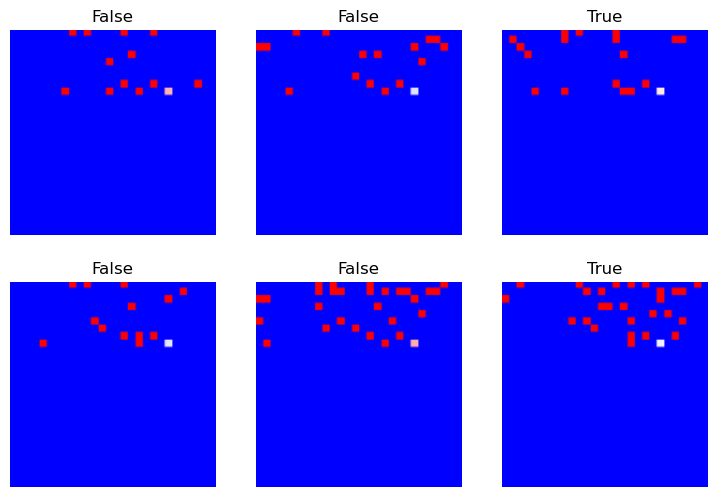

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='pad')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.201321,1.049041,0.438272,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.954695,0.777743,0.361111,01:33
1,0.829725,0.915030,0.277778,01:41
2,0.676088,0.886750,0.308642,01:34
3,0.503555,0.823135,0.299383,01:34
4,0.355098,0.836558,0.299383,01:34


In [8]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\vladc/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:02<00:00, 39.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.179445,0.988613,0.373457,02:01


epoch,train_loss,valid_loss,error_rate,time
0,0.903193,1.021419,0.453704,02:36
1,0.873301,0.869628,0.336420,02:53
2,0.770053,0.790538,0.314815,02:45
3,0.607110,0.828358,0.339506,02:53
4,0.425301,0.802423,0.324074,02:44


# Compare to Tabular Deep Learning

In [4]:
from fastai.tabular.all import *

# all columns
all_columns = df.columns.tolist()

# get target column
target_col = 'No_remission'

# get input columns
input_cols = [col for col in all_columns if col != target_col]

# get continuous variables
cont_cols = ['age_at_first_diagnosis']

# get categorical variables
cat_cols = [col for col in input_cols if col not in cont_cols]

dls = TabularDataLoaders.from_df(
    df = df,
    y_names = target_col,
    cat_names = cat_cols,
    cont_names = cont_cols,
    procs = [Categorify, FillMissing, Normalize]
)

learn = tabular_learner(dls, metrics=accuracy)

In [5]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.264439,0.316824,0.750000,00:01
1,0.221187,0.312032,0.750000,00:01
2,0.197847,0.261511,0.750000,00:02
3,0.176538,0.186113,0.750000,00:02
4,0.169886,0.179572,0.750000,00:02
